In [1]:
import pandas as pd  
# 指向Intergated-DATASET-D.csv的地址（预处理文件）
DATASET_B_PATH_WIN = 'D:/Working/PRP-2021/Data/Processed_Data/feature_analysis/Intergated-DATASET-D.csv'
# 读取数据文件 
data = pd.read_csv(DATASET_B_PATH_WIN).drop(['Unnamed: 0'], axis=1)

In [2]:
# 设置需要处理的空间网格区间的边界
# 范围不能太大，会超内存而无法运行
ROW_LIM_DOWN = int(data.row_id.min())
ROW_LIM_UP = int(data.row_id.max() - 110)
COL_LIM_DOWN = int(data.col_id.min())
COL_LIM_UP = int(data.col_id.max() - 110)
print((ROW_LIM_DOWN, ROW_LIM_UP, COL_LIM_DOWN, COL_LIM_UP))

(-139, -110, 0, 28)


In [3]:
# 选定待处理的空间网格区域
data = data.loc[(data.row_id >= ROW_LIM_DOWN)&(data.row_id <= ROW_LIM_UP) &(data.col_id >= COL_LIM_DOWN) & (data.col_id <= COL_LIM_UP)]
# 将所有网格id转换成int型
for c in ['row_id', 'col_id', 'time_id']:  
    data[c] = data[c].astype(int)
# 将date和id处理成正整数，然后排序
data['date'] -= data['date'].min()
data['row_id'] -= data['row_id'].min()
data['col_id'] -= data['col_id'].min()
data['time_id'] -= data['time_id'].min()
data = data.sort_values(['date', 'row_id', 'col_id', 'time_id']).reset_index(drop=True)

In [4]:
# 当前的data中存在着NaN值和缺失的网格，需要将NaN改成0，以及将缺失网格补全，由下面这个函数实现
def grid_recovery(df_, cols=[], lens=[]):
    df = df_.copy()
    lcols = len(cols)
    llens = len(lens)
    
    if lcols != llens: # 确保输入的网格名称和网格长度信息的长度一致
        raise ValueError(f'Lengths of cols ({lcols}) and lens ({llens}) mismatch.')
    
    recovery_df = None
    for c, l in zip(cols, lens):
        tmp_df = pd.DataFrame({c:range(l)})
        tmp_df['flag'] = True
        if recovery_df is None:
            recovery_df = tmp_df.copy()
        else:
            recovery_df = recovery_df.merge(tmp_df, 'left', 'flag')
    
    del recovery_df['flag']
    
    df = pd.merge(recovery_df, df, on=['date','row_id', 'col_id', 'time_id'])
    df = df.fillna(0)
    return df
    
NROWS = ROW_LIM_UP - ROW_LIM_DOWN + 1 # 空间网格行数  
NCOLS = COL_LIM_UP - COL_LIM_DOWN + 1 # 空间网格列数  
NTIME = data.time_id.max() - data.time_id.min() + 1 # 时间网格数  
NDATE = 30 # 日期网格数
data = grid_recovery(data, ['date', 'row_id', 'col_id', 'time_id'], [NDATE, NROWS, NCOLS, NTIME])  
for c in ['volume', 'stopNum']:  
    data[c] = data[c].astype(int) # 调整数据类型 

In [5]:
data

,date,row_id,col_id,time_id,aveSpeed,gridAcc,volume,speedStd,stopNum
0,0,0,5,9,15.571961,-2.323410,1,0.000000,0
1,0,0,5,12,10.679653,-0.098228,1,0.000000,0
2,0,0,5,15,12.348424,0.018499,2,1.345171,0
3,0,0,5,18,9.483641,0.109564,1,0.000000,0
4,0,0,5,24,12.754410,-0.000014,1,0.000000,0
...,...,...,...,...,...,...,...,...,...
1712141,29,29,28,265,12.844945,-0.097047,23,4.335740,0
1712142,29,29,28,266,13.059798,0.319253,15,3.569742,0
1712143,29,29,28,267,14.422607,-0.198924,8,2.596043,0
1712144,29,29,28,268,14.361599,-0.245811,10,2.369202,0


In [6]:
# 当前网格数太多了，可以进一步合并
data['hourid'] = data['time_id'] // 6 # 合并时间网格  
data['new_rowid'] = data.row_id // 2 # 合并空间网格  
data['new_colid'] = data.col_id // 2  
speed = data.groupby( # 计算合并网格后各网格的流量  
    ['date', 'new_rowid', 'new_colid', 'hourid']).aveSpeed.mean().reset_index()  
speed.columns = ['date', 'row_id', 'col_id', 'hourid', 'gridSpeed']  

In [7]:
speed

,date,row_id,col_id,hourid,gridSpeed
0,0,0,1,22,9.487764
1,0,0,1,28,7.454806
2,0,0,1,30,4.043013
3,0,0,1,40,3.455001
4,0,0,1,41,9.487989
...,...,...,...,...,...
186568,29,14,14,40,13.778830
186569,29,14,14,41,14.187796
186570,29,14,14,42,13.882866
186571,29,14,14,43,13.586276


In [8]:
TIME_UNIT = data.groupby('hourid').size().count() # 每个date里所包含的hourid的数量
TIME_UNIT

45

In [9]:
from math import ceil

In [10]:
speed_pivot = speed.pivot_table(  
    index=['date', 'hourid', 'row_id'],  
    columns='col_id',  
    values='gridSpeed').fillna(0).reset_index() # 网格转换  
speed_pivot['timeseq'] = speed_pivot['date'] * TIME_UNIT + speed_pivot['hourid'] # 时间序号  
speed_pivot_np = speed_pivot[[c for c in range(ceil(NCOLS/2))]].values # 提取速度数值

In [11]:
speed_pivot

col_id,date,hourid,row_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,timeseq
0,0,0,0,0.000000,0.000000,0.000000,18.864123,15.018503,15.510752,15.506765,0.000000,11.289351,0.000000,0.000000,0.000000,0.000000,0.000000,12.254730,0
1,0,0,1,0.000000,12.948501,16.064613,16.405718,17.971415,0.000000,0.000000,0.000000,12.933367,15.658056,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0,0,2,7.645916,9.487548,0.000000,15.741683,0.000000,0.000000,0.000000,0.000000,0.000000,17.039919,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,0,0,3,0.000000,0.000000,17.877262,14.660245,0.000000,0.000000,0.000000,0.000000,0.000000,16.553371,17.000271,0.000000,0.000000,0.000000,3.455001,0
4,0,0,4,0.000000,4.611076,13.133688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.895948,0.000000,0.000000,15.924881,11.671914,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20245,29,44,10,0.000000,12.680749,9.057302,6.889958,9.019047,0.000000,0.000000,4.073565,0.000000,4.525877,5.413401,9.462348,8.790477,10.133217,7.773832,1349
20246,29,44,11,12.858924,14.034164,0.000000,9.561180,7.681618,9.884326,11.364833,5.138832,7.117813,6.033746,7.209406,7.955900,10.051838,0.000000,7.869913,1349
20247,29,44,12,21.526924,18.634956,0.000000,7.919506,6.173840,9.776676,3.550290,4.677656,8.672387,10.732617,10.067527,11.264940,11.857768,7.087199,10.094117,1349
20248,29,44,13,0.000000,9.702068,9.821266,11.350801,10.567032,0.000000,8.380742,5.525176,6.237528,9.106948,9.474874,10.254112,11.349605,12.118581,11.295210,1349


In [12]:
import numpy as np
np.shape(speed_pivot_np)

(20250, 15)

In [13]:
print((ceil(NROWS/2),ceil(NCOLS/2)))

(15, 15)


In [14]:
# 数据增强
win_s = 10
win_t = 3
def gen_movie(df, nrows=ceil(NROWS/2), ncols=ceil(NCOLS/2), ntime=30*TIME_UNIT, win_s=win_s, win_t=win_t):  #注意：win_s必须得小于nrows,ncols!!!
    n_i = nrows - win_s + 1   
    n_j = ncols - win_s + 1   
    piece = []  
    for t in range(3*TIME_UNIT - 1, ntime):   #第一天末尾的hourid索引实际上是TIME_UNIT - 1，而不是TIME_UNIT
        for i in range(n_i):  
            for j in range(n_j):  
                # 周期特征  
                prd_piece = df[t-(3*TIME_UNIT - 1) : t - (TIME_UNIT - 1) + 1: TIME_UNIT, i:i+win_s, j:j+win_s]  
                # 邻近特征  
                nbr_piece = df[t-win_t:t+1, i:i+win_s, j:j+win_s]  
                piece.append(np.vstack([prd_piece, nbr_piece]))  
    return np.stack(piece)  

movie = gen_movie(np.asarray(speed_pivot_np.reshape(30*TIME_UNIT, ceil(NROWS/2), ceil(NCOLS/2)), order='C'))  

In [15]:
np.shape(speed_pivot_np.reshape(30*TIME_UNIT, ceil(NROWS/2), ceil(NCOLS/2)))

(1350, 15, 15)

In [16]:
np.shape(movie[:,:3])

(43776, 3, 10, 10)

In [17]:
np.save('data_x.npy', movie[:, :6])  #TODO:过去三小时的数据
np.save('data_y.npy', movie[:, 6])  #TODO:一、二、三天前的数据

In [50]:
import tensorflow as tf  
from tensorflow import keras  
from tensorflow.keras.layers import Conv2D, BatchNormalization  
from tensorflow.keras.layers import Activation, MaxPooling2D  
from tensorflow.keras.regularizers import l2
# 卷积层
"""
def conv_layer(inputs,  
             num_filters=16,  
             kernel_size=3,  
             strides=1,  
             data_format='channels_first',  
             activation='relu',  
             batch_normalization=True,  
             maxpooling=True,  
             pool_size=2,  
             pool_strides=2):  
    conv = Conv2D(num_filters,  
                 kernel_size=kernel_size,  
                 strides=strides,  
                 padding='same',  
                 data_format=data_format,  
                 kernel_regularizer=l2(1e-4))  
    x = conv(inputs)  # 卷积
    if batch_normalization:
        x = BatchNormalization()(x) # 批归一化
    if activation is not None:
        x = Activation(activation)(x) # 激活函数
    if maxpooling:
        x = MaxPooling2D(pool_size=pool_size,  
                        strides=pool_strides,  
                        data_format=data_format,  
                        padding='same')(x) # 池化
    return x
"""
def conv_layer(inputs,  
             num_filters=16,  
             kernel_size=3,  
             strides=1,  
             data_format='channels_last',  
             activation='relu',  
             batch_normalization=True,  
             maxpooling=True,  
             pool_size=2,  
             pool_strides=2):  
    conv = Conv2D(num_filters,  
                 kernel_size=kernel_size,  
                 strides=strides,  
                 padding='same',  
                 data_format=data_format,  
                 kernel_regularizer=l2(1e-4))  
    x = conv(inputs)  # 卷积
    if batch_normalization:
        x = BatchNormalization()(x) # 批归一化
    if activation is not None:
        x = Activation(activation)(x) # 激活函数
    if maxpooling:
        x = MaxPooling2D(pool_size=pool_size,  
                        strides=pool_strides,  
                        data_format=data_format,  
                        padding='same')(x) # 池化
    return x

"\ndef conv_layer(inputs,  \n             num_filters=16,  \n             kernel_size=3,  \n             strides=1,  \n             data_format='channels_first',  \n             activation='relu',  \n             batch_normalization=True,  \n             maxpooling=True,  \n             pool_size=2,  \n             pool_strides=2):  \n    conv = Conv2D(num_filters,  \n                 kernel_size=kernel_size,  \n                 strides=strides,  \n                 padding='same',  \n                 data_format=data_format,  \n                 kernel_regularizer=l2(1e-4))  \n    x = conv(inputs)  # 卷积\n    if batch_normalization:\n        x = BatchNormalization()(x) # 批归一化\n    if activation is not None:\n        x = Activation(activation)(x) # 激活函数\n    if maxpooling:\n        x = MaxPooling2D(pool_size=pool_size,  \n                        strides=pool_strides,  \n                        data_format=data_format,  \n                        padding='same')(x) # 池化\n    return x\n"

In [51]:
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num GPUs Available: ", len(tf.test.gpu_device_name()))

Num GPUs Available:  0


In [52]:
"""
from tensorflow.keras.layers import UpSampling2D  
def upsample_layer(inputs,  
                up_size=2,  
                interpolation='nearest',  
                data_format='channels_first'):
    upsample = UpSampling2D(size=up_size,
                    data_format=data_format,
                    interpolation=interpolation)  
    x = upsample(inputs) # 上采样
    return x
""""

def upsample_layer(inputs,  
                up_size=2,  
                interpolation='nearest',
                data_format='channels_last'):
    upsample = UpSampling2D(size=up_size,
                    data_format=data_format,
                    interpolation=interpolation)  
    x = upsample(inputs) # 上采样
    return x

"\nfrom tensorflow.keras.layers import UpSampling2D  \ndef upsample_layer(inputs,  \n                up_size=2,  \n                interpolation='nearest',  \n                data_format='channels_first'):\n    upsample = UpSampling2D(size=up_size,\n                    data_format=data_format,\n                    interpolation=interpolation)  \n    x = upsample(inputs) # 上采样\n    return x\n"

In [53]:
from tensorflow.keras.layers import Input, Flatten, Dense  
from tensorflow.keras.models import Model  
def cnn_model(input_shape):  
    inputs = Input(shape=input_shape)  
    x = conv_layer(inputs, 16, pool_strides=1)  
    x = conv_layer(x, 32, pool_strides=1)  
    x = conv_layer(x, 32, pool_strides=1)  
    x = conv_layer(x, 16)  
    x = upsample_layer(x, 2)  
    x = conv_layer(x, 1, maxpooling=False)  
    # y = Flatten(data_format='channels_first')(x)
    y = Flatten(data_format='channels_last')(x)
    y = Dense(128, activation='relu')(y)  
    y = Dense(128, activation='relu')(y)  
    outputs = Dense(100, activation='relu')(y)  
    # 建立模型  
    model = Model(inputs=inputs, outputs=outputs)  
    return model

In [54]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error      
from tensorflow.keras.callbacks import EarlyStopping    
SEED = 233  # 随机种子    
np.random.seed(SEED)    
# tf.random.set_random_seed(SEED)
tf.random.set_seed(SEED)

In [56]:
data_x = np.load('data_x.npy')    
data_y = np.load('data_y.npy')    
data_x = data_x.astype('float32')    
data_y = data_y.astype('float32')

In [57]:
(np.shape(data_x),np.shape(data_y))

((43776, 6, 10, 10), (43776, 10, 10))

In [58]:
N_SAMPLE_PER_HOUR = (ceil(NROWS/2) - win_s + 1) * (ceil(NCOLS/2) - win_s + 1) # 计算数据增强（裁剪）之后，一个hourid内的数据数量
N_SAMPLES_LAST_DAY = TIME_UNIT * N_SAMPLE_PER_HOUR #计算最后一天的样本（数据）量

Max = max(data_x.max(), data_y.max())

data_x /= Max # 归一化  
data_y /= Max # 归一化  #TODO:此处归一化的方法存疑
train_x, train_y = data_x[:-N_SAMPLES_LAST_DAY], data_y[:-N_SAMPLES_LAST_DAY] # 训练集     
test_x, test_y = data_x[-N_SAMPLES_LAST_DAY:], data_y[-N_SAMPLES_LAST_DAY:] # 测试集
model = cnn_model(train_x.shape[1:])      
opt = keras.optimizers.Adam(learning_rate=4e-4)      
model.compile(loss='mse',      
              optimizer=opt,      
              metrics=['mae', 'mse']) 

batch_size = 32 # 训练批次大小    
epochs = 50  # 训练轮数    
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # 早停策略    
# model.fit(train_x, train_y.reshape(-1, 100),      
#         batch_size=batch_size,      
#         epochs=epochs,       
#         validation_split=0.2,      
#         callbacks=[earlystop],      
#         shuffle=True) # 模型训练
model.fit(train_x, train_y.reshape(-1, 100),      
          batch_size=batch_size,      
          epochs=epochs,       
          validation_split=0.2,      
          callbacks=[earlystop],      
          shuffle=True) # 模型训练

Epoch 1/50
1054/1054 [==============================] - 13s 12ms/step - loss: 0.0487 - mae: 0.1412 - mse: 0.0416 - val_loss: 0.0326 - val_mae: 0.1066 - val_mse: 0.0272
Epoch 2/50
1054/1054 [==============================] - 13s 12ms/step - loss: 0.0298 - mae: 0.0981 - mse: 0.0256 - val_loss: 0.0280 - val_mae: 0.0977 - val_mse: 0.0249
Epoch 3/50
1054/1054 [==============================] - 13s 12ms/step - loss: 0.0266 - mae: 0.0923 - mse: 0.0241 - val_loss: 0.0248 - val_mae: 0.0927 - val_mse: 0.0228
Epoch 4/50
1054/1054 [==============================] - 13s 12ms/step - loss: 0.0241 - mae: 0.0883 - mse: 0.0225 - val_loss: 0.0233 - val_mae: 0.0878 - val_mse: 0.0220
Epoch 5/50
1054/1054 [==============================] - 13s 12ms/step - loss: 0.0234 - mae: 0.0869 - mse: 0.0222 - val_loss: 0.0231 - val_mae: 0.0889 - val_mse: 0.0220
Epoch 6/50
1054/1054 [==============================] - 13s 12ms/step - loss: 0.0229 - mae: 0.0860 - mse: 0.0219 - val_loss: 0.0226 - val_mae: 0.0861 - val_mse:

1054/1054 [==============================] - 13s 12ms/step - loss: 0.0164 - mae: 0.0724 - mse: 0.0159 - val_loss: 0.0172 - val_mae: 0.0753 - val_mse: 0.0167


In [59]:
# 计算误差
predictions_test = model.predict(test_x, batch_size=512)    
mae_test = mean_absolute_error(predictions_test * Max, test_y.reshape(-1, 100) * Max)    
mse_test = mean_squared_error(predictions_test * Max, test_y.reshape(-1, 100) * Max)    
print(mae_test, mse_test, np.sqrt(mse_test)) # 测试集误差 

1.6370162 8.113474 2.848416


In [60]:
np.shape(predictions_test)

(1620, 100)

<AxesSubplot:>

Text(0.5, 1.0, 'prediction')

<AxesSubplot:>

Text(0.5, 1.0, 'real')

<AxesSubplot:>

Text(0.5, 1.0, 'prediction')

<AxesSubplot:>

Text(0.5, 1.0, 'real')

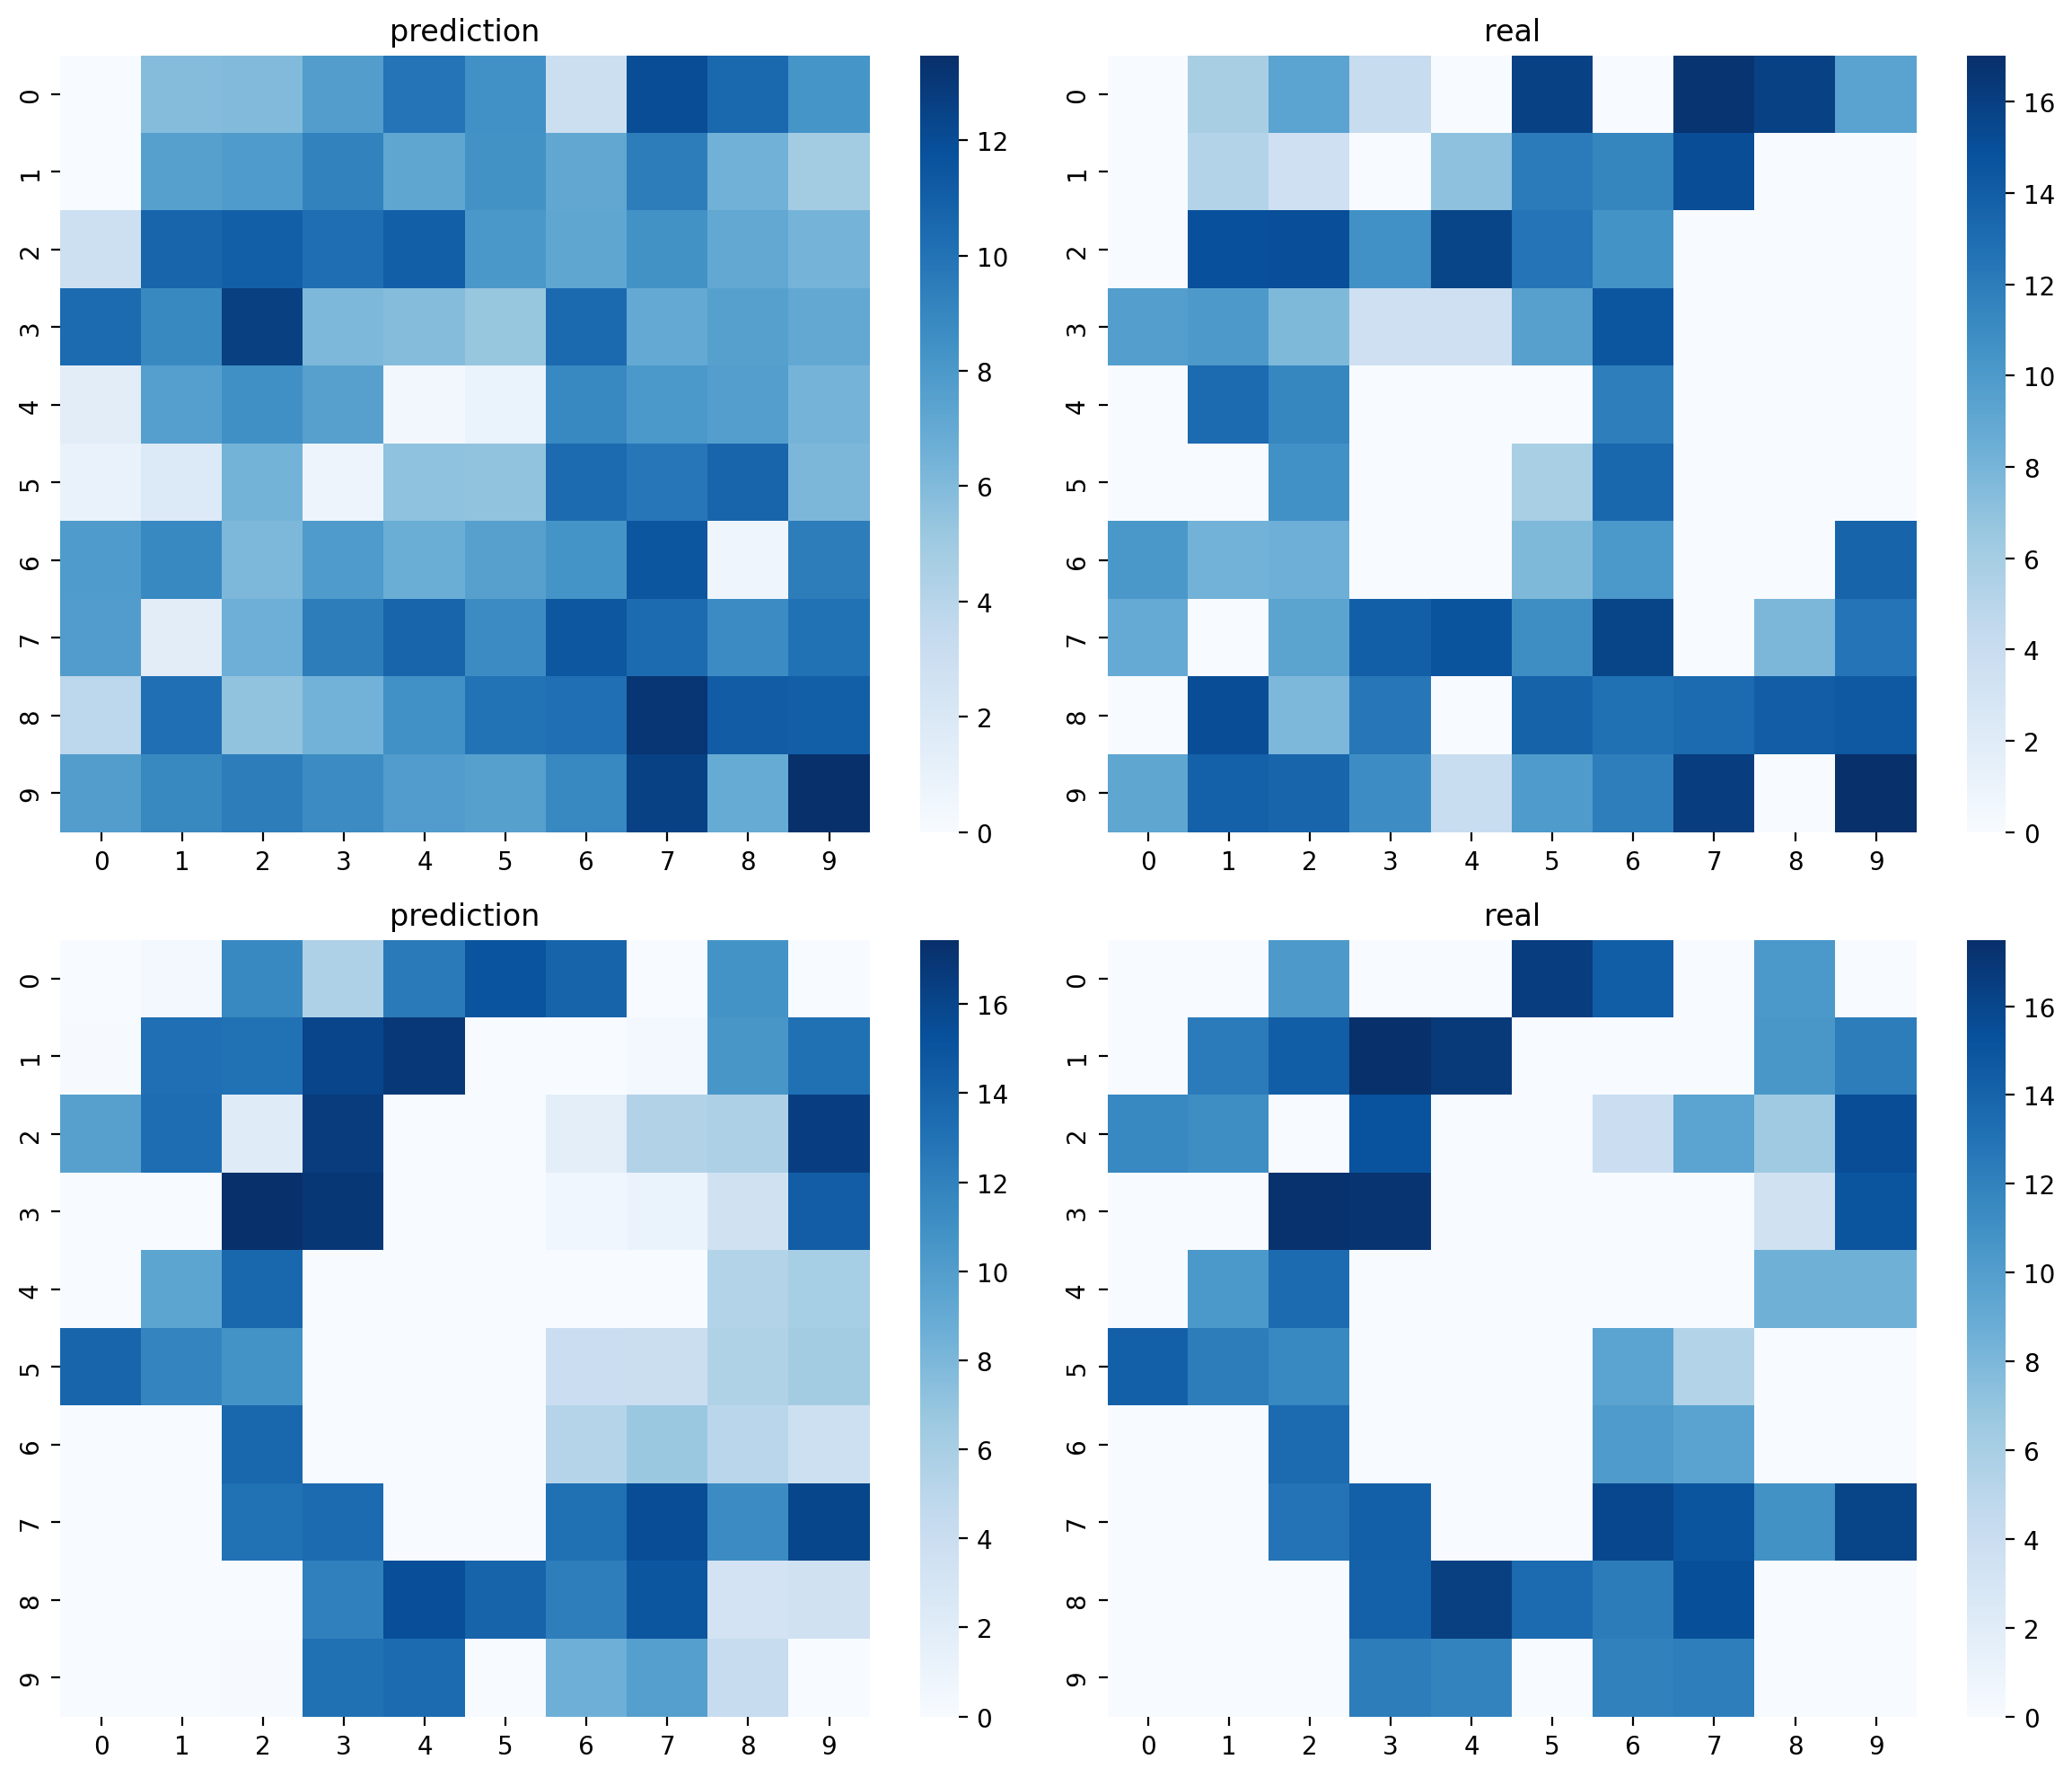

In [61]:
# 预测结果可视化
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(12, 10), dpi=200)
for idx, (axi, volframe) in enumerate(zip(ax.ravel(), [
    predictions_test[35].reshape(10,-1),
    test_y[35],
    predictions_test[36].reshape(10,-1),
    test_y[36],
])):
    sns.heatmap(volframe * Max, vmin=0, cmap='Blues', ax=axi)
    if idx % 2 == 0:
        axi.set_title('prediction')
    else:
        axi.set_title('real')
plt.tight_layout()
plt.show()


In [62]:
# 从铺平后的index到原本时空id的映射
def hourId(index:int,) -> int: 
    return (index+1)//N_SAMPLE_PER_HOUR

def rowId(index: int) -> int:
    return ((index+1)%N_SAMPLE_PER_HOUR)//ceil(NROWS/2)

def colId(index: int) ->int:
    return ((index+1)&N_SAMPLE_PER_HOUR)%ceil(NROWS/2)



# 定义从二维tuple到一维array索引的映射（限定二维平面的shape是(10,10)）
def flattenIndex(row,col):
    #计算卷积核的偏置
    row_offset = (row+1)%10 if (row > 9) else 0
    col_offset = (col+1)%10 if (col > 9) else 0
    #计算偏置还原后，该网格在(10,10)网格中的相对位置
    relativeRowId = row - row_offset
    relativeColId = col - col_offset
    #计算flattenIndex
    return 10*relativeRowId + relativeColId

In [63]:
flattenIndex(10,10)

99

In [64]:
def pickOneGrid(prediction, row_index, col_index, type:int):
    if((col_index > ceil(NCOLS/2) - 1) or (col_index < 0) or (row_index > ceil(NROWS/2) - 1) or (row_index < 0)):
        raise ValueError('The index is outside the boundary.')
    else:
        # 计算在prediction中对应的所有index
        index = []
        general_offset = 6*((row_index+1)%10 if (row_index > 9) else 0) + ((col_index+1)%10 if (col_index > 9) else 0)
        # 计算相对坐标
        row_offset = (row_index+1)%10 if (row_index > 9) else 0
        col_offset = (col_index+1)%10 if (col_index > 9) else 0
        #计算偏置还原后，该网格在(10,10)网格中的相对位置
        relativeRowId = row_index - row_offset
        relativeColId = col_index - col_offset
        print(f'general_offset is {general_offset}, relative coordinate is ({relativeRowId},{relativeColId})')
        if(type == 0):
            for i in range(np.shape(prediction)[0]):
                if(i%36 == general_offset):
                    index.append(prediction[i][flattenIndex(row_index, col_index)])
        else:
            for i in range(np.shape(prediction)[0]):
                if(i%36 == general_offset):
                    index.append(prediction[i][relativeRowId][relativeColId])
        return index


                

    
    

general_offset is 14, relative coordinate is (9,9)
general_offset is 14, relative coordinate is (9,9)


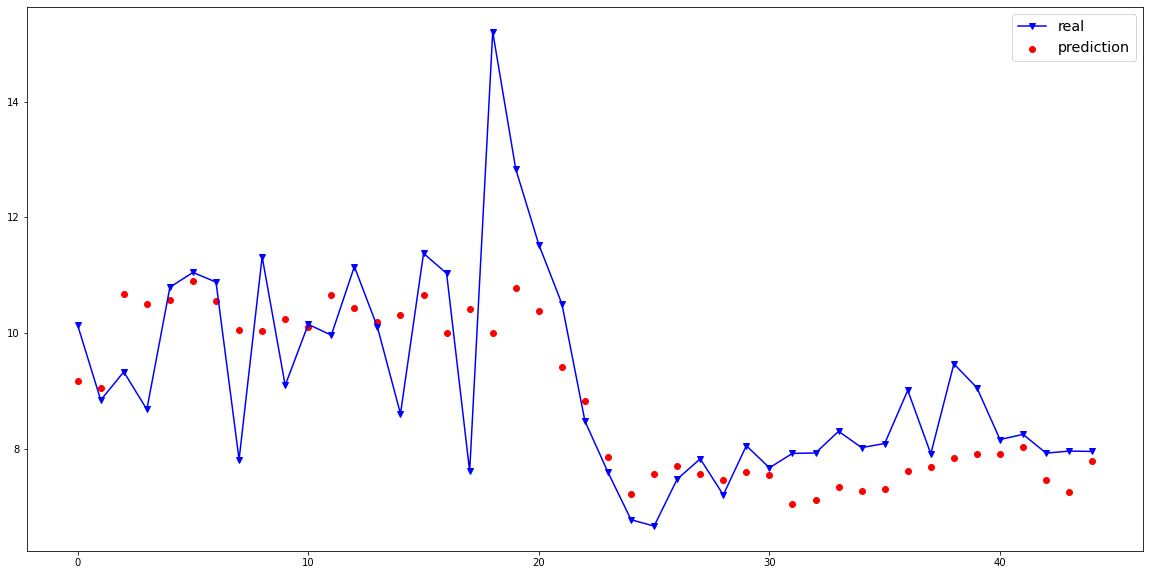

In [65]:
# 选择网格 # (0,0) ~ (14,14)
cord = (11,11)
last_day_predict = np.array(pickOneGrid(predictions_test, cord[0], cord[1], type=0))*Max
last_day_real    = np.array(pickOneGrid(test_y, cord[0], cord[1], type=1))*Max

# 画图
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(range(45), last_day_predict, c='r', marker='o', label='prediction')
ax.plot(range(45), last_day_real, c='b', marker='v', label='real')
legend = ax.legend(fontsize='x-large')
plt.show()